#  Survival Analysis on Telco Customer Churn

In [383]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import chi2
#from scipy.stats import chi2
from scipy.stats import chi2_contingency

from scipy.stats import t
from scipy.stats import ttest_ind

from lifelines.statistics import logrank_test
from lifelines.statistics import multivariate_logrank_test
from lifelines import KaplanMeierFitter
from sksurv.nonparametric import kaplan_meier_estimator 
from sksurv.preprocessing import OneHotEncoder
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored

import seaborn as sns 
%matplotlib inline 

import warnings
warnings.filterwarnings('ignore')

In [194]:
df = pd.read_csv('/Data Science/DSC/Capstone Project 1/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Data Wrangling

In [72]:
# Check the size of dataframe 

In [195]:
df.shape 

(7043, 21)

In [ ]:
#view the first five rows 

In [196]:
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# the detailed info of the first row 

In [197]:
df.iloc[0]

customerID                7590-VHVEG
gender                        Female
SeniorCitizen                      0
Partner                          Yes
Dependents                        No
tenure                             1
PhoneService                      No
MultipleLines       No phone service
InternetService                  DSL
OnlineSecurity                    No
OnlineBackup                     Yes
DeviceProtection                  No
TechSupport                       No
StreamingTV                       No
StreamingMovies                   No
Contract              Month-to-month
PaperlessBilling                 Yes
PaymentMethod       Electronic check
MonthlyCharges                 29.85
TotalCharges                   29.85
Churn                             No
Name: 0, dtype: object

In [ ]:
#check the datatype of each feature

In [198]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null int64
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
dtypes: float64(1), int64(2), obj

In [199]:
# check missing values 
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

## Data Types Transformation

In [200]:
# The feature SeniorCitizen indicates whether the customer is a senior citizen or not (1, 0)
# so we need to convert it into catogorical type 
# The feature TotalCharges indicates the total amount charged to the customer
# so we nned to convert it into numerical type 
df['SeniorCitizen'] = df['SeniorCitizen'].astype('category')
df['TotalCharges_num'] = pd.to_numeric(df['TotalCharges'],errors='coerce')

In [ ]:
# double check the data types have been successfully converted 

In [201]:
df.dtypes

customerID            object
gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges          object
Churn                 object
TotalCharges_num     float64
dtype: object

In [ ]:
# Check the descriptive statistics for numerical features
# However, the converted TotalCharges generate 11 missing values 
# which means the origical TotalCharges has some invaid values, even though they appear non-missing values 

In [202]:
df.describe()

,tenure,MonthlyCharges,TotalCharges_num
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


In [ ]:
# check missling values again 

In [203]:
for col in df.columns:
    print(col,df[col].isnull().sum())

customerID 0
gender 0
SeniorCitizen 0
Partner 0
Dependents 0
tenure 0
PhoneService 0
MultipleLines 0
InternetService 0
OnlineSecurity 0
OnlineBackup 0
DeviceProtection 0
TechSupport 0
StreamingTV 0
StreamingMovies 0
Contract 0
PaperlessBilling 0
PaymentMethod 0
MonthlyCharges 0
TotalCharges 0
Churn 0
TotalCharges_num 11


## Missing Data Imputation

In [ ]:
# I discovered that there are 11 observations whose TotalCahrges is string of spaces( missing data)
# we impute them with 0 

In [204]:
df[df['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,NaN
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,NaN
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,NaN


In [205]:
df[df['TotalCharges_num'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,NaN
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,NaN
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,NaN
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,NaN
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,NaN
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,NaN
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,NaN
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,NaN
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,NaN
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,NaN


In [ ]:
# Impute the missing data on TotalCharges_num

In [206]:
df.loc[df['TotalCharges_num'].isnull(),'TotalCharges_num']  = 0

In [207]:
df[df['tenure'] == 0]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,TotalCharges_num
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,,No,0.0
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,,No,0.0
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,No,Yes,Yes,Two year,No,Mailed check,80.85,,No,0.0
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,,No,0.0
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,,No,0.0
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,,No,0.0
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,,No,0.0
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,,No,0.0
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,,No,0.0
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,No,Two year,No,Mailed check,73.35,,No,0.0


In [208]:
# The feature TotalCharges_num's missing values have been imputed
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null category
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
TotalCharges_num    7043 non-n

In [209]:
df.describe()

,tenure,MonthlyCharges,TotalCharges_num
count,7043.000000,7043.000000,7043.000000
mean,32.371149,64.761692,2279.734304
std,24.559481,30.090047,2266.794470
min,0.000000,18.250000,0.000000
25%,9.000000,35.500000,398.550000
50%,29.000000,70.350000,1394.550000
75%,55.000000,89.850000,3786.600000
max,72.000000,118.750000,8684.800000


In [210]:
# check the distribution of target variable 
df.Churn.value_counts()/len(df)

No     0.73463
Yes    0.26537
Name: Churn, dtype: float64

In [ ]:
# even though the distribution of TotalCharges is postivaly skewed and the distribution of MonthlyCharges 
# has a great number of obersavtions in the low of monthly charges (not distributed normally), I wouldn't 
# treat them as outliers according the business senece, espetially we will apply survival analysis in this case

# Exploratory Data Analysis (EDA)
Q: **What is the distribution of those three nemerical variables? How would you explain them?**

A: The distribution of total charges is very positively skewed. The majority of customers are charged under \$2000.

The distribution of tenure shows a relatively stable trend between 10 months and 60 months. However, significant
number of customers stayed with business below 10 months(new customers)  or above 60 months(loyal cutomers).

As for the distribution of monthly charges, above \$30 and beyond, it distributes nearly normal. 
However low-end customers with less than \\$30 accounts for a large portion. 

Text(0, 0.5, 'Number of Customers')

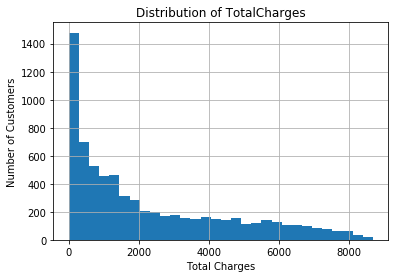

In [211]:
fig = df.TotalCharges_num.hist(bins=30)
fig.set_title('Distribution of TotalCharges')
fig.set_xlabel('Total Charges')
fig.set_ylabel('Number of Customers')

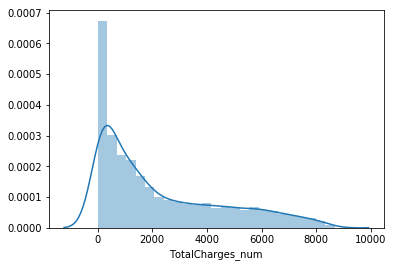

In [212]:
sns.distplot(df.TotalCharges_num)

Text(0, 0.5, 'Number of Customers')

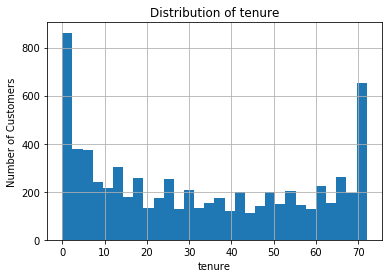

In [213]:
fig = df.tenure.hist(bins=30)
fig.set_title('Distribution of tenure')
fig.set_xlabel('tenure')
fig.set_ylabel('Number of Customers')

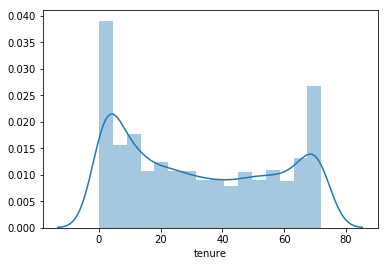

In [214]:
sns.distplot(df.tenure)

Text(0, 0.5, 'Number of Customers')

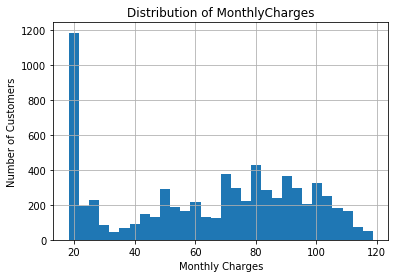

In [215]:
fig = df.MonthlyCharges.hist(bins=30)
fig.set_title('Distribution of MonthlyCharges')
fig.set_xlabel('Monthly Charges')
fig.set_ylabel('Number of Customers')

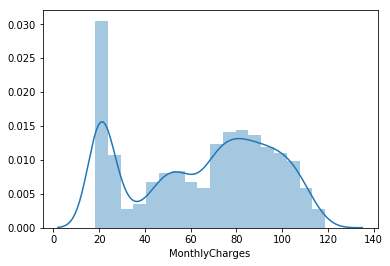

In [216]:
sns.distplot(df.MonthlyCharges)

In [217]:
df.dtypes

customerID            object
gender                object
SeniorCitizen       category
Partner               object
Dependents            object
tenure                 int64
PhoneService          object
MultipleLines         object
InternetService       object
OnlineSecurity        object
OnlineBackup          object
DeviceProtection      object
TechSupport           object
StreamingTV           object
StreamingMovies       object
Contract              object
PaperlessBilling      object
PaymentMethod         object
MonthlyCharges       float64
TotalCharges          object
Churn                 object
TotalCharges_num     float64
dtype: object

**Q: What is the distribution of those three nemerical variables? How would you explain them?**

A: From a business perspective, we ignore the first feature customerID.
   For all other categorical feature,  the largest number of different labels is 4. So the cardinality is not high, so    that it is not likely cause overfitting 
   And the relatively rare labels is 9% for 'NO' values of Phoneservice 9% for 'No phone service' of MultipleLines
   this also is unlikely to cause overfitting

In [218]:

categorical_col = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 
                   'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                   'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling','PaymentMethod']
numerical_col = ['tenure','MonthlyCharges','TotalCharges_num']
for col in categorical_col:
    print(col)
    print(df[col].value_counts()/len(df))
    print('------------------------')

gender
Male      0.504756
Female    0.495244
Name: gender, dtype: float64
------------------------
SeniorCitizen
0    0.837853
1    0.162147
Name: SeniorCitizen, dtype: float64
------------------------
Partner
No     0.516967
Yes    0.483033
Name: Partner, dtype: float64
------------------------
Dependents
No     0.700412
Yes    0.299588
Name: Dependents, dtype: float64
------------------------
PhoneService
Yes    0.903166
No     0.096834
Name: PhoneService, dtype: float64
------------------------
MultipleLines
No                  0.481329
Yes                 0.421837
No phone service    0.096834
Name: MultipleLines, dtype: float64
------------------------
InternetService
Fiber optic    0.439585
DSL            0.343746
No             0.216669
Name: InternetService, dtype: float64
------------------------
OnlineSecurity
No                     0.496663
Yes                    0.286668
No internet service    0.216669
Name: OnlineSecurity, dtype: float64
------------------------
OnlineBacku

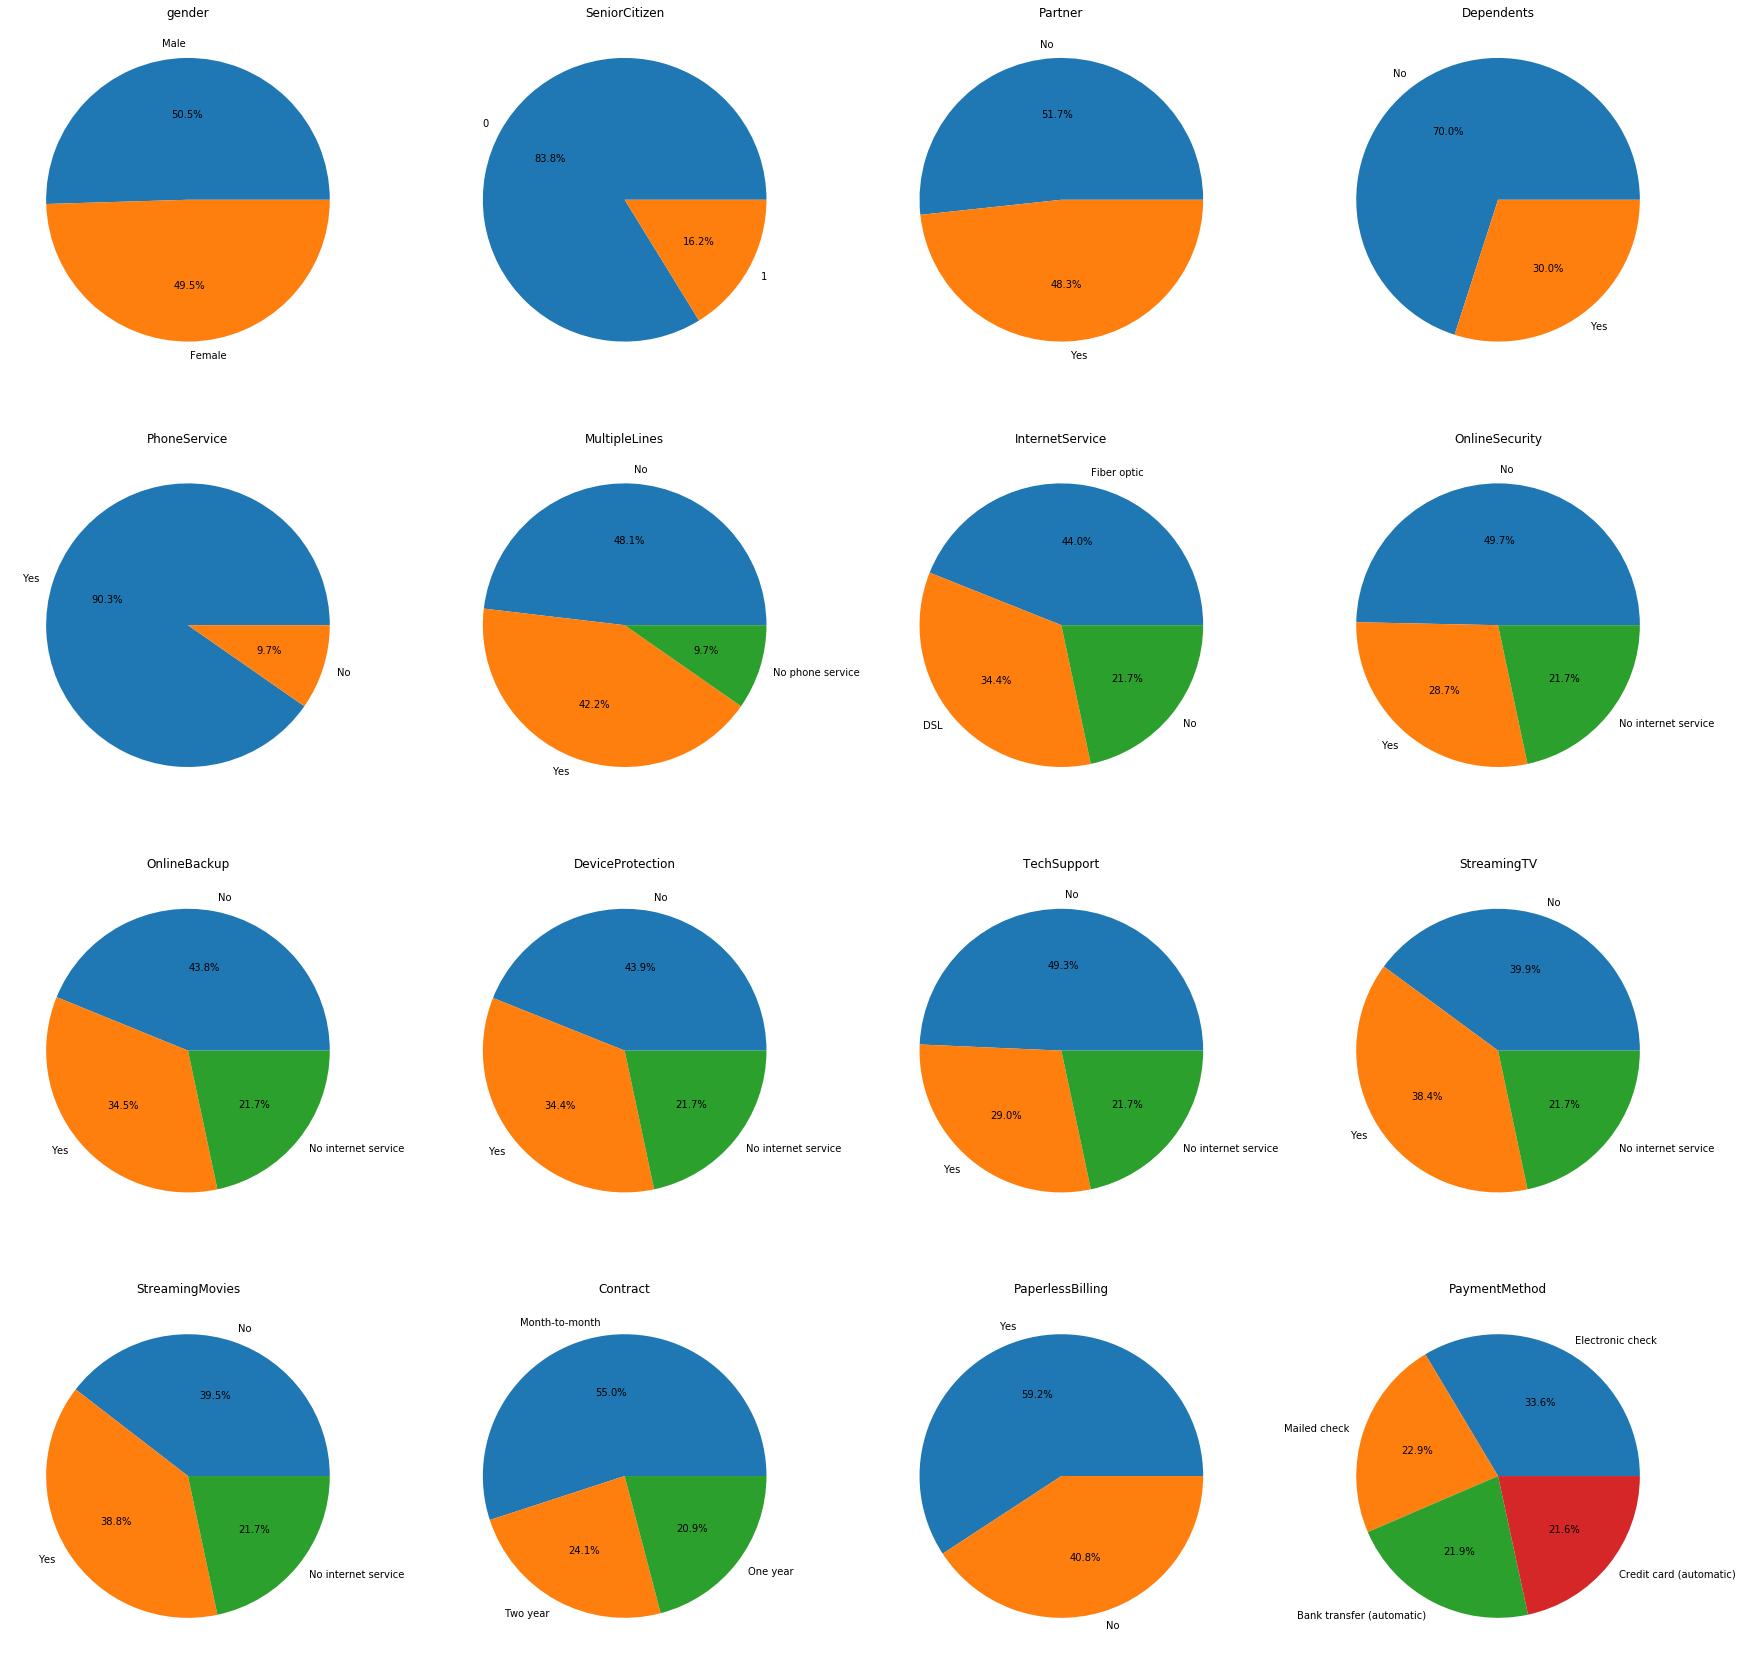

In [219]:
fig, axs = plt.subplots(4,4,figsize=(30,30))
for i, ax in enumerate(axs.reshape(-1)):
    col = categorical_col[i]
    ax.pie(df[col].value_counts(), autopct='%1.1f%%',labels=df[col].value_counts().index)
    ax.set_title(col)

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 22 columns):
customerID          7043 non-null object
gender              7043 non-null object
SeniorCitizen       7043 non-null category
Partner             7043 non-null object
Dependents          7043 non-null object
tenure              7043 non-null int64
PhoneService        7043 non-null object
MultipleLines       7043 non-null object
InternetService     7043 non-null object
OnlineSecurity      7043 non-null object
OnlineBackup        7043 non-null object
DeviceProtection    7043 non-null object
TechSupport         7043 non-null object
StreamingTV         7043 non-null object
StreamingMovies     7043 non-null object
Contract            7043 non-null object
PaperlessBilling    7043 non-null object
PaymentMethod       7043 non-null object
MonthlyCharges      7043 non-null float64
TotalCharges        7043 non-null object
Churn               7043 non-null object
TotalCharges_num    7043 non-n

# Statistical Data Analysis

## Frequentist Inference
**Q: If we divide all observations into two groups: churned and not-churned. How does the numerical variables's mean 
   differ between both groups? How would you explaing them statistically?**
   
A: The result of t-test indicates that statistically significance does exist since p-values are all extremely low. So we can confidenty reject the null hypothere and conclude that all these numerical variables differs between two groups. Please also be noteed that these three variables were considered individually.  
   For this particular project, we are going to perform survival analysis, we should treat variable 'tenure' as time factor that may bring censoring issue.  This will be addressed in model building and model performance evaluation that follows.
   
### t-test for MonthlyCharges, Totalcharges and tenure 

In [221]:
group0 = df[df['Churn'] == 'No']['MonthlyCharges']
group1 = df[df['Churn'] == 'Yes']['MonthlyCharges']

print('the mean of MonthlyCharge for not churned: ',np.mean(group0))
print('the mean of MonthlyCharge for churned: ', np.mean(group1))

ttest_ind(group0,group1)

the mean of MonthlyCharge for not churned:  61.2651236953999
the mean of MonthlyCharge for churned:  74.4413322632423


Ttest_indResult(statistic=-16.53673801593631, pvalue=2.706645606888261e-60)

In [222]:
group0 = df[df['Churn'] == 'No']['TotalCharges_num']
group1 = df[df['Churn'] == 'Yes']['TotalCharges_num']

print('the mean of TotalCharges for not churned: ',np.mean(group0))
print('the mean of TotalCharges for churned: ', np.mean(group1))

ttest_ind(group0,group1)


the mean of TotalCharges for not churned:  2549.911441824514
the mean of TotalCharges for churned:  1531.7960941680035


Ttest_indResult(statistic=16.978779727124437, pvalue=2.127211613240394e-63)

In [223]:
group0 = df[df['Churn'] == 'No']['tenure']
group1 = df[df['Churn'] == 'Yes']['tenure']

print('the mean of tenure for not churned: ',np.mean(group0))
print('the mean of tenure for churned: ', np.mean(group1))

ttest_ind(group0,group1)

the mean of tenure for not churned:  37.56996521066873
the mean of tenure for churned:  17.979133226324237


Ttest_indResult(statistic=31.57955051135377, pvalue=7.99905796059022e-205)

**Q: Since the majority of the features are categorical,after we had an idea about cardinality, we are more interested in how each labeled groups affect the  performance of time-event in the context of survival analysis.**

A: Rather than using traditional chi-square contigence table, we use Log rank test together with Kaplan-Meier curve to figue out how those groups differ from each other. 
   The diagram below indicates that out the 16 categorical variables, only "gender" and 'PhoneService" have large value of p-values. We don't have sufficient evidence to reject null hypothesis for them. 

## Log rank test for all categorical variables 

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  -log2(p)
          0.53 0.47      1.09


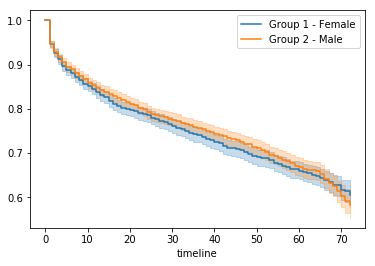

In [224]:
# for 'gender'
group1 = df[df['gender'] == 'Female']
group2 = df[df['gender'] == 'Male']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Female").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Male").plot(ax=ax)

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
        109.49 <0.005     82.71


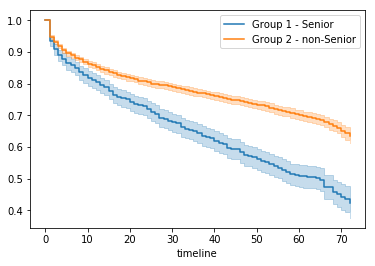

In [99]:
# SeniorCitizen
group1 = df[df['SeniorCitizen'] == 1]
group2 = df[df['SeniorCitizen'] == 0]
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Senior").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - non-Senior").plot(ax=ax)

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
        423.54 <0.005    310.21


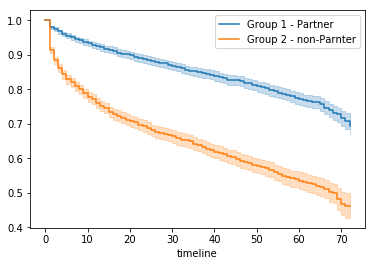

In [225]:
# Partner
group1 = df[df['Partner'] == 'Yes']
group2 = df[df['Partner'] == 'No']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Partner").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - non-Parnter").plot(ax=ax)

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
        232.70 <0.005    172.12


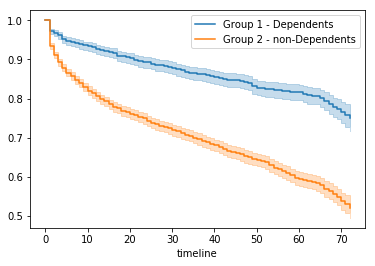

In [103]:
#Dependents        
group1 = df[df['Dependents'] == 'Yes']
group2 = df[df['Dependents'] == 'No']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Dependents").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - non-Dependents").plot(ax=ax)

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()        


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic    p  -log2(p)
          0.43 0.51      0.97


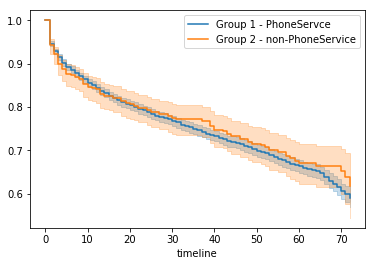

In [226]:
# PhoneService
group1 = df[df['PhoneService'] == 'Yes']
group2 = df[df['PhoneService'] == 'No']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - PhoneServce").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - non-PhoneService").plot(ax=ax)

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary()        

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic      p  -log2(p)
        805.49 <0.005    581.04


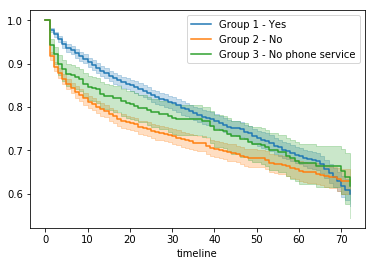

In [227]:
#MultipleLines


group1 = df[df['MultipleLines'] == 'Yes']
group2 = df[df['MultipleLines'] == 'No']
group3 = df[df['MultipleLines'] == 'No phone service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Yes").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - No").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No phone service").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['MultipleLines'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()
#esults=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
#results.print_summary() 

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic    p  -log2(p)
          9.15 0.01      6.60


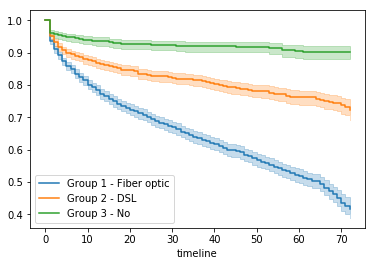

In [115]:
#InternetService

group1 = df[df['InternetService'] == 'Fiber optic']
group2 = df[df['InternetService'] == 'DSL']
group3 = df[df['InternetService'] == 'No']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Fiber optic").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - DSL").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['InternetService'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()
        


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic      p  -log2(p)
        731.48 <0.005    527.65


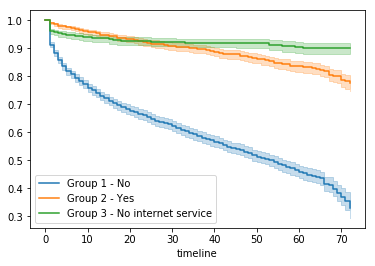

In [228]:
#OnlineSecurity


group1 = df[df['OnlineSecurity'] == 'No']
group2 = df[df['OnlineSecurity'] == 'Yes']
group3 = df[df['OnlineSecurity'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['OnlineSecurity'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()
        


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic      p  -log2(p)
        938.01 <0.005    676.63


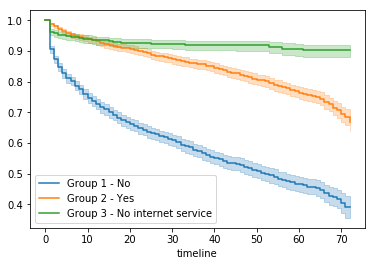

In [229]:
#OnlineBackup

group1 = df[df['OnlineBackup'] == 'No']
group2 = df[df['OnlineBackup'] == 'Yes']
group3 = df[df['OnlineBackup'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['OnlineBackup'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic      p  -log2(p)
        944.26 <0.005    681.14


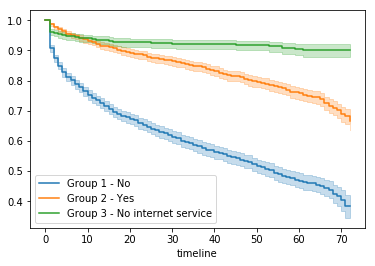

In [230]:
#DeviceProtection

        
group1 = df[df['DeviceProtection'] == 'No']
group2 = df[df['DeviceProtection'] == 'Yes']
group3 = df[df['DeviceProtection'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['DeviceProtection'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()     


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic      p  -log2(p)
        700.22 <0.005    505.10


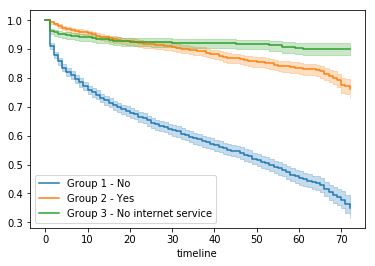

In [231]:
#TechSupport
        
group1 = df[df['TechSupport'] == 'No']
group2 = df[df['TechSupport'] == 'Yes']
group3 = df[df['TechSupport'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['TechSupport'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary() 


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic      p  -log2(p)
        552.60 <0.005    398.62


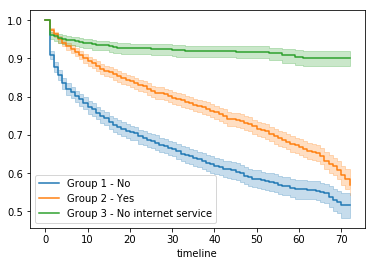

In [232]:
# StreamingTV
group1 = df[df['StreamingTV'] == 'No']
group2 = df[df['StreamingTV'] == 'Yes']
group3 = df[df['StreamingTV'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['StreamingTV'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary() 

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic      p  -log2(p)
        586.98 <0.005    423.42


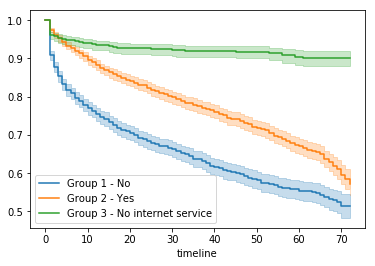

In [233]:
# StreamingMovies
group1 = df[df['StreamingMovies'] == 'No']
group2 = df[df['StreamingMovies'] == 'Yes']
group3 = df[df['StreamingMovies'] == 'No internet service']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - No").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Yes").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - No internet service").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['StreamingMovies'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary() 

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 2

---
test_statistic      p  -log2(p)
       3774.21 <0.005       inf


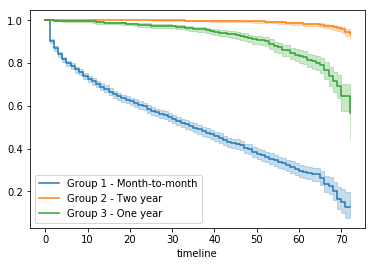

In [234]:
#Contract

        
        
group1 = df[df['Contract'] == 'Month-to-month']
group2 = df[df['Contract'] == 'Two year']
group3 = df[df['Contract'] == 'One year']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Month-to-month").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Two year").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - One year").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['Contract'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary()      


<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1

---
test_statistic      p  -log2(p)
        189.51 <0.005    140.82


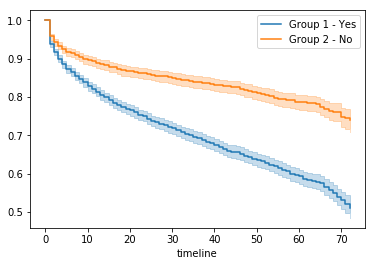

In [235]:
#PaperlessBilling

group1 = df[df['PaperlessBilling'] == 'Yes']
group2 = df[df['PaperlessBilling'] == 'No']
T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Yes").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - No").plot(ax=ax)

results=logrank_test(T,T1,event_observed_A=E, event_observed_B=E1)
results.print_summary() 

<lifelines.StatisticalResult>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 3

---
test_statistic      p  -log2(p)
       1108.40 <0.005    794.81


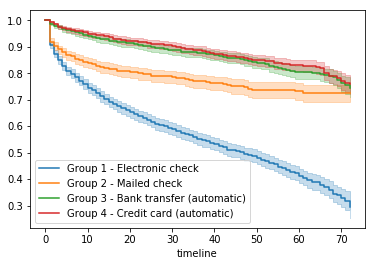

In [236]:
#PaymentMethod

        
group1 = df[df['PaymentMethod'] == 'Electronic check']
group2 = df[df['PaymentMethod'] == 'Mailed check']
group3 = df[df['PaymentMethod'] == 'Bank transfer (automatic)']
group4 = df[df['PaymentMethod'] == 'Credit card (automatic)']

T = group1['tenure']
E = np.where(group1['Churn'] == 'Yes',1,0)
T1 = group2['tenure']
E1 = np.where(group2['Churn'] == 'Yes',1,0)
T2 = group3['tenure']
E2 = np.where(group3['Churn'] == 'Yes',1,0)
T3 = group4['tenure']
E3 = np.where(group4['Churn'] == 'Yes',1,0)

kmf = KaplanMeierFitter()

ax = plt.subplot(111)
ax = kmf.fit(T, E, label="Group 1 - Electronic check").plot(ax=ax)
ax = kmf.fit(T1, E1, label="Group 2 - Mailed check").plot(ax=ax)
ax = kmf.fit(T2, E2, label="Group 3 - Bank transfer (automatic)").plot(ax=ax)
ax = kmf.fit(T3, E3, label="Group 4 - Credit card (automatic)").plot(ax=ax)

result = multivariate_logrank_test(df['tenure'], df['PaymentMethod'], df['Churn'])
result.test_statistic
result.p_value
result.print_summary() 



# Model Building
## Kaplan Meier Estimator

In [237]:
# use scikit-survival  KM estimator
event = np.where(df['Churn'] == 'Yes',True,False)
time,survival_prob = kaplan_meier_estimator(event,df['tenure'])

Text(0.5, 1.0, 'Kaplan Meier Curve')

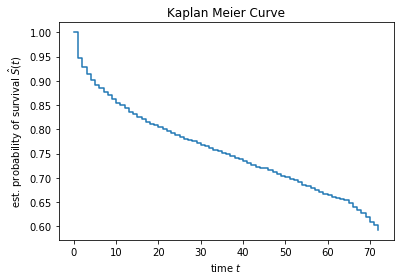

In [238]:
# Plot Kaplan Meier curve
plt.step(time,survival_prob,where = 'post')
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.title('Kaplan Meier Curve')

In [363]:
# create independent variable list without 'tenure'
col = categorical_col + numerical_col
col.remove('tenure')
#col.remove('MonthlyCharges')
#col.remove('TotalCharges_num')

In [365]:
for i in categorical_col:
    df[i] = df[i].astype('category')

## Categorical Features Encoding

In [366]:
from sksurv.preprocessing import OneHotEncoder
data_x = OneHotEncoder().fit_transform(df[col])
data_x.head(10)

,gender=Male,SeniorCitizen=1,Partner=Yes,Dependents=Yes,PhoneService=Yes,MultipleLines=No phone service,MultipleLines=Yes,InternetService=Fiber optic,InternetService=No,OnlineSecurity=No internet service,...,StreamingMovies=No internet service,StreamingMovies=Yes,Contract=One year,Contract=Two year,PaperlessBilling=Yes,PaymentMethod=Credit card (automatic),PaymentMethod=Electronic check,PaymentMethod=Mailed check,MonthlyCharges,TotalCharges_num
0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,29.85,29.85
1,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,56.95,1889.50
2,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,53.85,108.15
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,42.30,1840.75
4,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,70.70,151.65
5,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,99.65,820.50
6,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,89.10,1949.40
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,29.75,301.90
8,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,104.80,3046.05
9,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,56.15,3487.95


## create structured array of (churn tenure) pair

In [367]:
data_y = np.zeros(len(df), dtype={'names':('Churn', 'tenure'),
                          'formats':('bool' ,'i4')})
data_y['Churn'] = np.where(df['Churn'] =='Yes',True,False)
data_y['tenure'] = df['tenure']
data_x_unique = data_x.T.drop_duplicates().T

## Cox proportional hazards model

In [368]:
from sksurv.linear_model import CoxPHSurvivalAnalysis

scaler = StandardScaler()
data_x_unique_std = scaler.fit_transform(data_x_unique)
estimator = CoxPHSurvivalAnalysis()
estimator.fit(data_x_unique_std,data_y)

CoxPHSurvivalAnalysis(alpha=0, n_iter=100, ties='breslow', tol=1e-09, verbose=0)

In [369]:
pd.Series(estimator.coef_, index=data_x_unique.columns)

gender=Male                             -2.271692e-02
SeniorCitizen=1                          2.043703e-02
Partner=Yes                             -7.837669e-02
Dependents=Yes                          -4.791815e-02
PhoneService=Yes                         4.630993e+14
MultipleLines=No phone service           4.630993e+14
MultipleLines=Yes                        4.624558e-02
InternetService=Fiber optic              4.857987e-01
InternetService=No                      -9.162337e-01
OnlineSecurity=Yes                      -8.911255e-02
OnlineBackup=Yes                        -2.262861e-02
DeviceProtection=Yes                     4.398923e-02
TechSupport=Yes                         -2.877963e-02
StreamingTV=Yes                          1.440183e-01
StreamingMovies=Yes                      1.430785e-01
Contract=One year                       -5.248708e-01
Contract=Two year                       -1.582502e+00
PaperlessBilling=Yes                     8.078248e-02
PaymentMethod=Credit card (a

No handles with labels found to put in legend.


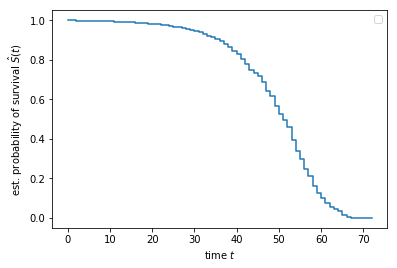

In [371]:
# Check baseline survival function 
plt.step(estimator.baseline_survival_.x, estimator.baseline_survival_.y, where="post")
plt.ylabel("est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.legend(loc="best")

# Model Performance Evaluation

In [377]:
prediction = estimator.predict(data_x_unique_std)
result = concordance_index_censored(data_y["Churn"], data_y["tenure"], prediction)
result[0]estimator.score(data_x_numeric,data_y)

0.9268272178248246

In [378]:
estimator.score(data_x_unique_std,data_y)

0.9268272178248246

# Feature Selection

In [388]:
def fit_and_score_features(X, y):
    n_features = X.shape[1]
    scores = np.empty(n_features)
    m = CoxPHSurvivalAnalysis()
    for j in range(n_features):
        Xj = X[:, j:j+1]
        m.fit(Xj, y)
        scores[j] = m.score(Xj, y)
    return scores

scores = fit_and_score_features(data_x_unique_std, data_y)
pd.Series(scores, index=data_x_unique.columns).sort_values(ascending=False)


TotalCharges_num                         0.870078
Contract=Two year                        0.658445
PaymentMethod=Electronic check           0.645168
Partner=Yes                              0.630619
InternetService=Fiber optic              0.610313
OnlineSecurity=Yes                       0.610310
TechSupport=Yes                          0.608456
Contract=One year                        0.603240
OnlineBackup=Yes                         0.597314
DeviceProtection=Yes                     0.589353
Dependents=Yes                           0.585176
PaymentMethod=Credit card (automatic)    0.577269
PaperlessBilling=Yes                     0.572174
InternetService=No                       0.569642
MultipleLines=Yes                        0.551465
SeniorCitizen=1                          0.537364
StreamingMovies=Yes                      0.537024
StreamingTV=Yes                          0.534922
MonthlyCharges                           0.509718
gender=Male                              0.507630


In [387]:
pipe = Pipeline([('select', SelectKBest(fit_and_score_features, k=3)),
                 ('model', CoxPHSurvivalAnalysis())])

In [389]:
param_grid = {'select__k': np.arange(1, data_x_unique_std.shape[1] + 1)}
gcv = GridSearchCV(pipe, param_grid, return_train_score=True, cv=3, iid=True)
gcv.fit(data_x_unique_std, data_y)


GridSearchCV(cv=3, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('select',
                                        SelectKBest(k=3,
                                                    score_func=<function fit_and_score_features at 0x1a26240158>)),
                                       ('model',
                                        CoxPHSurvivalAnalysis(alpha=0,
                                                              n_iter=100,
                                                              ties='breslow',
                                                              tol=1e-09,
                                                              verbose=0))],
                                verbose=False),
             iid=True, n_jobs=None,
             param_grid={'select__k': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23])},
             pre_dispatch='2*n_jobs', refit=

In [390]:
pd.DataFrame(gcv.cv_results_).sort_values(by='mean_test_score', ascending=False)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_select__k,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
13,15.740232,0.051268,0.928634,0.929246,14,{'select__k': 14},1,0.932485,0.926632,0.926170,0.930808,0.927245,0.930299,0.197627,0.003420,0.002759,0.001860
15,15.929948,0.057054,0.928160,0.928557,16,{'select__k': 16},2,0.931955,0.925822,0.925806,0.930089,0.926717,0.929761,0.331702,0.012107,0.002710,0.001939
14,15.807357,0.054725,0.928118,0.928728,15,{'select__k': 15},3,0.931629,0.926041,0.925996,0.930378,0.926730,0.929766,0.211529,0.001031,0.002500,0.001917
16,16.445310,0.052694,0.928071,0.928469,17,{'select__k': 17},4,0.931852,0.925842,0.926740,0.929951,0.925621,0.929613,0.160699,0.001836,0.002712,0.001862
18,16.284186,0.053394,0.927805,0.928422,19,{'select__k': 19},5,0.930188,0.926311,0.926615,0.929894,0.926611,0.929059,0.314361,0.003171,0.001685,0.001531
17,17.522265,0.054836,0.927744,0.928539,18,{'select__k': 18},6,0.930855,0.926099,0.926541,0.929880,0.925835,0.929636,1.222816,0.003182,0.002219,0.001728
22,28.101984,0.050044,0.927694,0.928813,23,{'select__k': 23},7,0.930585,0.927009,0.926219,0.930001,0.926278,0.929427,0.610794,0.003841,0.002045,0.001297
19,16.592942,0.055082,0.927422,0.928428,20,{'select__k': 20},8,0.930227,0.926295,0.925577,0.929903,0.926462,0.929087,0.547807,0.003841,0.002016,0.001545
21,28.878502,0.049366,0.927366,0.928463,22,{'select__k': 22},9,0.930298,0.926373,0.925747,0.930046,0.926053,0.928969,1.151299,0.003791,0.002077,0.001542
20,22.187607,0.054791,0.927336,0.928454,21,{'select__k': 21},10,0.930544,0.926582,0.925455,0.929860,0.926009,0.928921,6.623429,0.000083,0.002280,0.001378
